In [1]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available

True


In [2]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM, AutoTokenizer
import json

In [3]:
import gc  # Adicione esta importação no início do script
from IPython import get_ipython

# 1. Remova todas as referências ao modelo e dados
if 'model' in globals():
    del model  # Remove a referência do escopo global

if 'inputs' in globals():
    del inputs

# 2. Force a coleta de lixo
gc.collect()

# 3. Limpe o cache da CUDA
torch.cuda.empty_cache()

# 4. Verifique a memória liberada
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"\n✅ GPUs disponíveis: {num_gpus}\n")

    for i in range(num_gpus):
        props = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {props.name}")
        print(f"  - Memória total: {props.total_memory / (1024 ** 3):.2f} GB")
        print(f"  - Memória livre: {torch.cuda.memory_reserved(i) / (1024 ** 3):.2f} GB (reservada)")
        print(f"  - Memória alocada: {torch.cuda.memory_allocated(i) / (1024 ** 3):.2f} GB (em uso)")
        print()
else:
    print("❌ Nenhuma GPU CUDA disponível.")


✅ GPUs disponíveis: 1

GPU 0: NVIDIA GeForce RTX 4060 Ti
  - Memória total: 15.57 GB
  - Memória livre: 0.00 GB (reservada)
  - Memória alocada: 0.00 GB (em uso)



In [4]:
lab_name = 'OpenGVLab'
model_name = 'InternVL2_5-1B'
model_name = 'InternVL2_5-2B'
model_name = 'InternVL3-8B'
# model_name = 'InternVL3-1B'
# model_name = 'InternVL3-9B'
model_name = 'InternVL3-2B'
# model_name = 'InternVL3-1B'

# model_name = 'InternVL3-14B'

# model_name = 'InternVL2_5-4B'
# model_name = 'InternVL2_5-8B'
# model_name = 'InternVL2_5-4B-AWQ'
# model_name = 'InternVL2_5-8B-AWQ'

In [5]:
print(model_name)

InternVL3-2B


In [6]:
import sys
from pathlib import Path

# Caminho para a pasta src/ (um nível acima de notebooks/)
root_dir = Path.cwd().parent
src_dir = root_dir / "src"

# Adiciona src/ ao sys.path
sys.path.append(str(src_dir))

# Agora o import deve funcionar
from utils.image_utils import load_image, show_pair
from inference.classifier import classify_document

In [7]:
# lab_name = 'internvl-local'
# model_name = 'internvl_finetuned_1'

In [ ]:
# !code ~/hf_models/internvl3-14b-completo/snapshots/17da586d2a2f259853f586fad16b02e6380e62b0/config.json

In [7]:
# Carregar modelo e processador do Deepseek
#model_path = "llava-hf/llava-v1.6-mistral-7b-hf"  ##LlavaNextProcessor, LlavaNextForConditionalGeneration
# model_path = "Intel/llava-llama-3-8b" ## AutoProcessor, AutoModelForPreTraining
# model_path = "THUDM/cogvlm2-llama3-chat-19B" ## AutoProcessor, AutoModelForCausalLM
model_path = f"{lab_name}/{model_name}" ## AutoProcessor, AutoModelForCausalLM
# model_path = "/home/joaopaulo/.cache/huggingface/hub/models--internvl-local--internvl_finetuned_1"

# Configuração de quantização (opcional)
quant_config = {
    "load_in_4bit": True,
    "bnb_4bit_compute_dtype": torch.bfloat16
}

# Carregar modelo e processador
processor = AutoProcessor.from_pretrained(model_path, 
                                        #   local_files_only=True, 
                                          trust_remote_code=True
                                          )

model = AutoModelForCausalLM.from_pretrained(
    model_path,
    # local_files_only=True,  # 👈 fixa na versão atual (pode ser um commit exato também)
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    **quant_config
).eval()

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True, use_fast=False)

In [9]:
from data.documentpairs import DocumentPairDataset

dataset = DocumentPairDataset(
    csv_path="../../once_learning_dataset/once_learning_pairs_balanceado.csv",
    base_dir="../../once_learning_dataset/images",
    input_size=448,
    max_num=12,
    device="cuda"
)

In [10]:
# Acessar os caminhos originais do primeiro item
import os

row = dataset.df.iloc[0]

reference_image_path = os.path.join(dataset.base_dir, row["file_a_path"])
image_path          = os.path.join(dataset.base_dir, row["file_b_path"])

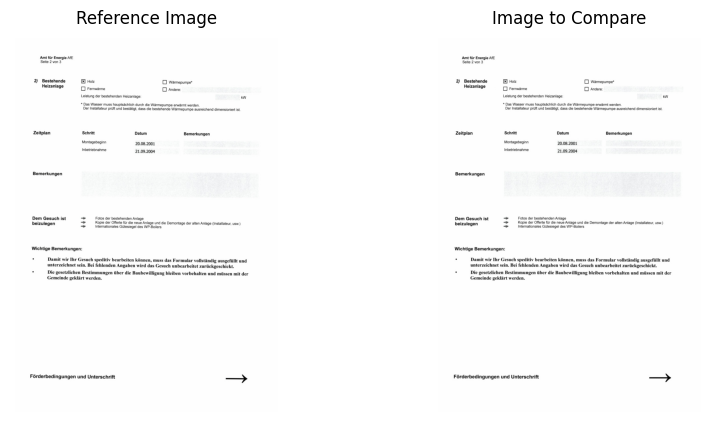

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


```json
{
    "similarity_score": 80,
    "category": "Highly Similar",
    "justification": "Both documents have similar layout structures, including headings, sections, and sub-sections. They contain text about installation timing and contact details with placeholders and arrows. The presence of important placeholders and structured text indicates they are designed to guide users or fill out specific information forms."
}
```


In [11]:
# Mostrar as imagens lado a lado
show_pair(reference_image_path, image_path)

# Classificar o par usando o modelo InternVL3
resultado = classify_document(reference_image_path, image_path, model, tokenizer)
print(resultado)

In [12]:
# <image>
# <|vision_start|><|vision_end|>

question = '''
<image>

You are an AI assistant specialized in document analysis. Your task is to analyze the **layout and structure** of the provided company document image.

**Instructions:**
Carefully examine the image and focus on describing:
- **Shapes and Elements:** Presence of tables, sections, headers, logos, and graphical components.
- **Layout Consistency:** Alignment of text blocks, margins, and general spatial organization.
- **Content Type:** What kind of content the document predominantly contains (e.g., forms, paragraphs, tables).

**Objective:**
Generate a **compact internal representation** that captures the visual and structural characteristics of the document for similarity comparison.

**Important:**
- Do not perform OCR or extract textual content.
- Focus only on the **visual layout and structure**.

**Output:**
Provide a concise summary suitable for internal comparison tasks, without any conclusions about similarity.
'''

In [13]:
def prepare_inputs_for_multimodal_embedding(model, tokenizer, pixel_values, question, num_patches=None):
    device = model.device

    if '<image>' not in question:
        question = '<image>\n' + question

    if num_patches is None:
        num_patches = pixel_values.shape[0]  # número de blocos/imagens

    # Criar espaço de input para os vit_embeds
    image_tokens = '<img>' + ('<IMG_CONTEXT>' * model.num_image_token * num_patches) + '</img>'
    question = question.replace('<image>', image_tokens, 1)

    inputs = tokenizer(question, return_tensors='pt').to(device)
    return {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'pixel_values': pixel_values.to(device),
        'image_flags': torch.ones(pixel_values.shape[0], dtype=torch.long).to(device)
    }

In [14]:
import os
import torch
import pandas as pd
from tqdm import tqdm

# --- 1. CONFIGURAÇÃO ---
# Caminhos
MODEL_PATH = f"OpenGVLab/InternVL3-2B" # Use o caminho local se já baixou
INPUT_MANIFEST_CSV = '../data/sampled_dataset_png/manifest_linux.csv'
IMAGES_BASE_DIR = '../data/sampled_dataset_png' # A pasta que contém as subpastas rvl-cdip, XFUND, etc.
OUTPUT_EMBEDDINGS_DIR = 'embeddings' # Nova pasta para salvar os tensores .pt
generation_config = dict(max_new_tokens=1024, do_sample=True)

In [15]:
dados = pd.read_csv(INPUT_MANIFEST_CSV)

In [16]:
relative_filepath = dados['filepath'][0]
image_path = os.path.join(IMAGES_BASE_DIR, relative_filepath)
pixel_values = load_image(image_path, max_num=12).to(model.device)

In [28]:
!ls /mnt

data


In [29]:
import os
import torch
import pandas as pd
from tqdm import tqdm

# --- 1. CONFIGURAÇÃO ---
# Caminhos
MODEL_PATH = f"OpenGVLab/InternVL3-2B" # Use o caminho local se já baixou
INPUT_MANIFEST_CSV = '../data/sampled_dataset_png/manifest_linux.csv'
IMAGES_BASE_DIR = '../data/sampled_dataset_png' # A pasta que contém as subpastas rvl-cdip, XFUND, etc.
OUTPUT_EMBEDDINGS_DIR = '/mnt/data/embeddings' # Nova pasta para salvar os tensores .pt

# --- 4. CARREGAMENTO DO MANIFESTO ---
if not os.path.exists(INPUT_MANIFEST_CSV):
    print(f"❌ Erro: Arquivo de manifesto '{INPUT_MANIFEST_CSV}' não encontrado.")
    exit()

df = pd.read_csv(INPUT_MANIFEST_CSV)
print(f"📰 Manifesto carregado. {len(df)} imagens para processar.")

# --- 5. PROCESSAMENTO E SALVAMENTO DOS EMBEDDINGS ---
print("\nIniciando a geração dos embeddings...")

# Limpar cache da GPU antes de começar
torch.cuda.empty_cache()

for index, row in tqdm(df.iterrows(), total=len(df), desc="Gerando Embeddings"):
    relative_filepath = row['filepath']
    image_path = os.path.join(IMAGES_BASE_DIR, relative_filepath)

    # Constrói o caminho de saída para o embedding
    # Ex: embeddings/rvl-cdip/images/a/a/a/aaa06d00.pt
    output_filename = os.path.splitext(relative_filepath)[0] + '.pt'
    output_path = os.path.join(OUTPUT_EMBEDDINGS_DIR, output_filename)

    # --- Lógica para pular arquivos já processados ---
    if os.path.exists(output_path):
        continue

    try:
        # Garante que o diretório de saída exista
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        # Carrega a imagem
        pixel_values = load_image(image_path, max_num=12).to(model.device)
        
        # Realiza a inferência
        with torch.no_grad():
            inputs = prepare_inputs_for_multimodal_embedding(model, tokenizer, pixel_values, question)
            outputs = model(**inputs, output_hidden_states=True, return_dict=True)

        # Extrai o embedding bruto (sequência de tokens) da última camada
        # e move para a CPU para economizar VRAM
        embedding = outputs.hidden_states[-1][0].cpu()

        # Salva o tensor no arquivo .pt
        torch.save(embedding, output_path)

    except FileNotFoundError:
        print(f"\n⚠️  Aviso: Imagem não encontrada, pulando: {image_path}")
    except Exception as e:
        print(f"\n❌ Erro ao processar o arquivo {image_path}: {e}")

print("\n--- Concluído! ---")
print(f"✅ Processamento de embeddings finalizado. Os arquivos foram salvos em '{OUTPUT_EMBEDDINGS_DIR}'.")

📰 Manifesto carregado. 9885 imagens para processar.

Iniciando a geração dos embeddings...


Gerando Embeddings:   0%|          | 0/9885 [00:00<?, ?it/s]

Gerando Embeddings:   1%|          | 101/9885 [01:10<1:34:53,  1.72it/s]


❌ Erro ao processar o arquivo ../data/sampled_dataset_png/Datasets/DIVA-HisDB/img-CB55/img/training/e-codices_fmb-cb-0055_0072v_max.png: image file is truncated


Gerando Embeddings: 100%|██████████| 9885/9885 [1:56:38<00:00,  1.41it/s]  


--- Concluído! ---
✅ Processamento de embeddings finalizado. Os arquivos foram salvos em '/mnt/data/embeddings'.


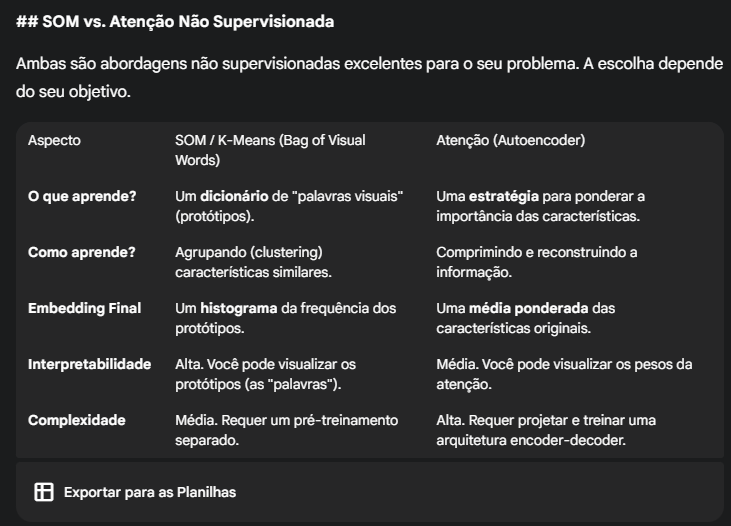